<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/GANs/DUDL_GAN_CNNganGaus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import sys

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create the data

In [3]:
n_images = 3000
img_size = 64

x    = np.linspace(start=-4, stop=4, num=img_size)
X, Y = np.meshgrid(x, x)

# Initialize tensors containing images and labels
images = torch.zeros(n_images, 1, img_size, img_size)

for i in range(n_images):
    
    # Create the gaussian with random centers
    # Ro = random offset
    # `i % 2`: Even image belong to label 0
    ro    = 2 * np.random.randn(2)
    width = np.random.rand() / 0.6 + 1.8 # Random width
    G     = np.exp(-((X - ro[0]) ** 2 + (Y - ro[1]) ** 2) / (2 * width ** 2))
    
    # And add noise
    G += np.random.randn(img_size, img_size) / 5
    
    # Add to the tensor
    # `.view`: Convert from numpy matrix to PTorch Tensor
    images[i, :, :, :] = torch.tensor(G).view(1, img_size, img_size)

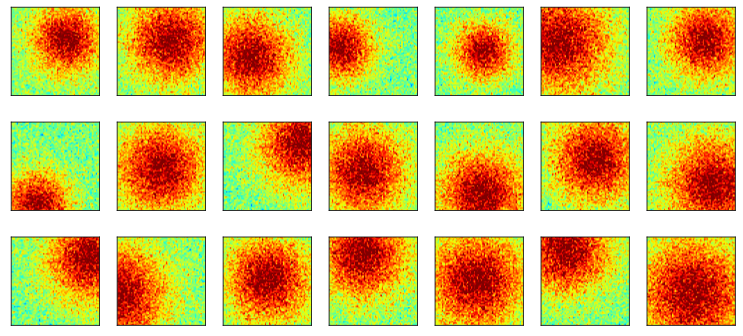

In [4]:
# Visualize some images
fig, axs = plt.subplots(3, 7, figsize=(13, 6))

for i, ax in enumerate(axs.flatten()):
    which_pic = np.random.randint(n_images)
    G         = np.squeeze(images[which_pic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

# Create classes for the discriminator and generator

In [ ]:
# Architecture and meta-parameter choices were inspired by https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [5]:
class discriminator_net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers
        self.conv1 = nn.Conv2d(1,    64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv2 = nn.Conv2d(64,  128, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv5 = nn.Conv2d(512,   1, kernel_size=4, stride=1, padding=0, bias=False)

        # Batchnorm
        self.bn2 = nn.BatchNorm2d(num_features=128)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.bn4 = nn.BatchNorm2d(num_features=512)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), negative_slope=0.2)
        x = F.leaky_relu(self.conv2(x), negative_slope=0.2)
        x = self.bn2(x)
        x = F.leaky_relu(self.conv3(x), negative_slope=0.2)
        x = self.bn3(x)
        x = F.leaky_relu(self.conv4(x), negative_slope=0.2)
        x = self.bn4(x)

        return torch.sigmoid(self.conv5(x)).view(-1, 1)

d_net = discriminator_net()
y     = d_net(torch.randn(10, 1, 64, 64))
y.shape

torch.Size([10, 1])

torch.Size([10, 1, 64, 64])

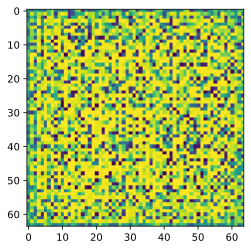

In [8]:
class generator_net(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolution layers
        self.conv1 = nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False)
        self.conv2 = nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv3 = nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv4 = nn.ConvTranspose2d(128,  64, kernel_size=4, stride=2, padding=1, bias=False)
        self.conv5 = nn.ConvTranspose2d(64,   1,  kernel_size=4, stride=2, padding=1, bias=False)

        # Batchnorm
        self.bn1 = nn.BatchNorm2d(num_features=512)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.bn3 = nn.BatchNorm2d(num_features=128)
        self.bn4 = nn.BatchNorm2d(num_features=64)
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = torch.tanh(self.conv5(x))

        return x
    
g_net = generator_net()
y     = g_net(torch.randn(10, 100, 1, 1))
plt.imshow(y[0, :, :, :].squeeze().detach().numpy());
y.shape

# Train the models!

In [9]:
# Loss Function (Same for both phases of training)
loss_func = nn.BCELoss()

# Create instance of the models
d_net = discriminator_net().to(device)
g_net = generator_net()    .to(device)

# Optimizers (Same algo but different variables b/c different parameters)
d_optimizer = torch.optim.Adam(d_net.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(g_net.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
## TRAINING ##
num_epochs              = 1500
batch_size              = 86
losses                  = []
discriminator_decisions = []

for epoch_i in range(num_epochs):

    # Create minibatches of REAL and FAKE images
    rand_idx = torch.randint(images.shape[0], (batch_size, ))
    data     = images[rand_idx, :]               .to(device)

    # Labels used for REAL and FAKE images
    real_labels = torch.ones (batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    
    ########################### Train the Discriminator ########################
    # Forward pass and loss for REAL images
    pred_real   = d_net(data)                       # REAL images into Discriminator
    d_loss_real = loss_func(pred_real, real_labels) # All labels are 1

    # Forward pass and loss for FAKE images
    fake_data   = torch.randn(batch_size, 100, 1, 1).to(device)
    fake_images = g_net(fake_data)                  # Output of generator
    pred_fake   = d_net(data)                       # FAKE images into Discriminator
    d_loss_fake = loss_func(pred_fake, fake_labels) # All labels are 0

    d_loss = d_loss_real + d_loss_fake

    # Backprop
    d_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()
    
    ############################ Train the Generator ###########################
    # Create fake images and compute loss
    fake_images = g_net(torch.randn(batch_size, 100, 1, 1).to(device))
    pred_fake   = d_net(fake_images)

    # Compute and collect loss and accuracy
    g_loss = loss_func(pred_fake, real_labels)

    # Backprop
    g_optimizer.zero_grad()
    g_loss.backward()
    g_optimizer.step()

    losses.append([d_loss.item(), g_loss.item()])
    d1 = torch.mean((pred_real > 0.5).float()).detach()
    d2 = torch.mean((pred_fake > 0.5).float()).detach()
    discriminator_decisions.append([d1, d2])

    ############################################################################
    # Print out a status message
    if ((epoch_i + 1) % 50 == 0):
        msg = 'Finished epoch {:<4}/{:<4}'.format(epoch_i + 1, num_epochs)
        sys.stdout.write('\r' + msg)

# Convert performance from list to Numpy array
losses                  = np.array(losses)

Finished epoch 1500/1500

TypeError: ignored

In [12]:
discriminator_decisions = np.array(discriminator_decisions.to(device))

AttributeError: ignored

In [ ]:
# create a 1D smoothing filter
def smooth(x,k=15):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(smooth(losses[:, 0]))
ax[0].plot(smooth(losses[:, 1]))
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend(['Discrimator', 'Generator'])
ax[0].set_xlim([4000, 5000])

ax[1].plot(losses[200:, 0], losses[200:, 1], 'k.', alpha=0.1)
ax[1].set_xlabel('Discriminator Loss')
ax[1].set_ylabel('Generator Loss')

ax[2].plot(smooth(discriminator_decisions[:, 0]))
ax[2].plot(smooth(discriminator_decisions[:, 1]))
ax[2].plot(discriminator_decisions)
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Probability ("Real")')
ax[2].set_title('Discriminator Output')
ax[2].legend(['Real', 'Fake'])

plt.show()

# Let's see some generated Gaussians!

In [ ]:
# Generage the images from the generator network
g_net.eval()
fake_data = g_net(torch.randn(batch_size, 100, 1, 1).to(device)).cpu()

fig, axs = plt.subplots(3, 6, figsize=(12, 6))
for (i, ax) in enumerate(axs.flatten()):
    ax.imshow(fake_data[i, :].detach().squeeze(), cmap='jet')
    ax.axis('off')

plt.show()

# Additional explorations

In [ ]:
# 1) Train the model for 200 epochs. Do the generated Gaussians still look like Gaussians?
# 
# 2) The images are set to 64x64. Does the model still work if you make the images larger, e.g., 91x91? How about if
#    they are smaller, e.g., 28x28 (the size of MNIST)?
# 